# Homework 8:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [52]:
# Import relevant libraries
library(tidyverse)
library(boot)

# Import data
setwd('/Users/jenahblack/Documents/Current_Coursework/Data_Science/DataSciencePsychNeuro_CMU85732/Homeworks/hcp_data')
hcp_data <- read.csv('unrestricted_trimmed_1_7_2020_10_50_44.csv')

d1 <- hcp_data %>% 
  select(Subject,
         Gender,
         Flanker_Unadj,
         FS_IntraCranial_Vol,
         FS_Tot_WM_Vol,
         FS_Total_GM_Vol) %>%
  mutate(Gender_numeric = ifelse(Gender == 'F', 1, 0)) %>% # for the logistic model, so I know which is which
  na.omit()

anyNA(d1)

head(d1)


[1] FALSE

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol,Gender_numeric
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
2,100206,M,130.42,1864518,543134,807245,0
3,100307,F,112.56,1512540,407292,664124,1
4,100408,M,121.18,1684117,500417,726206,0
5,100610,M,126.53,1816044,512946,762308,0
6,101006,F,101.85,1437868,429449,579632,1
7,101107,M,107.04,1512727,416995,665024,0


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

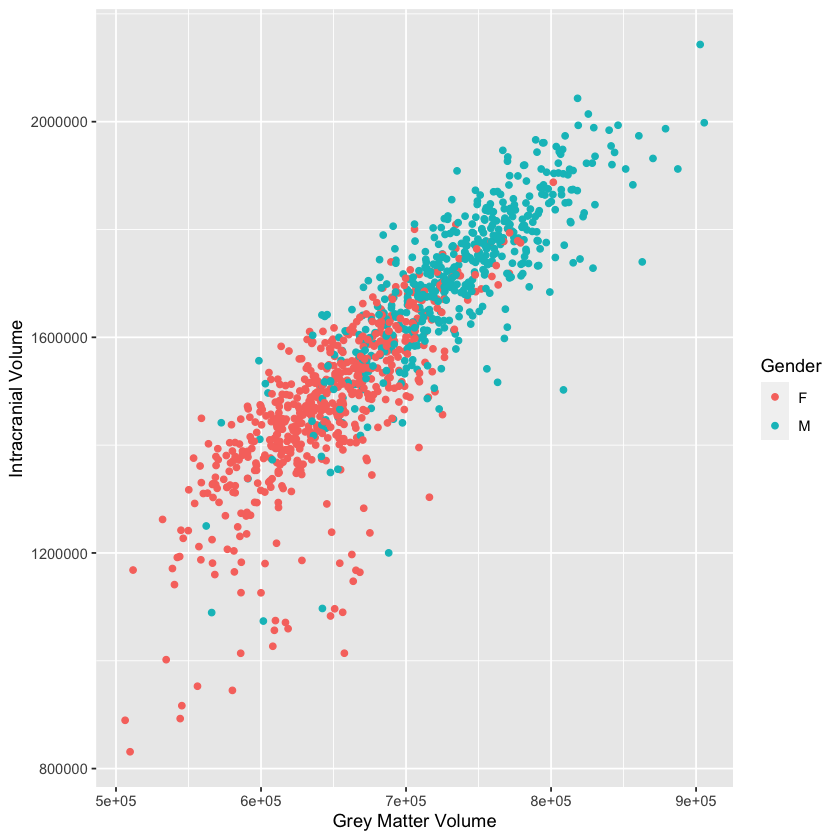

In [53]:
ggplot(d1, aes(x = FS_Total_GM_Vol, y = FS_IntraCranial_Vol, color = Gender)) +
  geom_point() +
  labs(x = 'Grey Matter Volume', # place holder so the space for the tx-axis title remains (from subject facets)
       y = 'Intracranial Volume',
       legend = 'Gender')


What patterns do you observe in the scatter plot?

> Grey matter volume and intracranial volume vary together in a positive direction.
> While there is a large amount of variability, female participants generally have less intracranial and grey matter volume that male participant.
> 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [54]:
logistic_gender_model <- glm(Gender_numeric ~ FS_Total_GM_Vol + FS_IntraCranial_Vol + FS_Tot_WM_Vol, data = d1, family = 'binomial')
summary(logistic_gender_model)

# Call:
#   glm(formula = as.factor(Gender) ~ FS_Total_GM_Vol + FS_IntraCranial_Vol + 
#         FS_Tot_WM_Vol, family = "binomial", data = d1)
# 
# Deviance Residuals: 
#   Min       1Q   Median       3Q      Max  
# -2.7695  -0.6173  -0.1863   0.5997   3.2309  
# 
# Coefficients:
#   Estimate Std. Error z value Pr(>|z|)    
# (Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
#   FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
#   FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
#   FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
# ---
#   Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
# 
# (Dispersion parameter for binomial family taken to be 1)
# 
# Null deviance: 1534.13  on 1112  degrees of freedom
# Residual deviance:  919.85  on 1109  degrees of freedom
# AIC: 927.85
# 
# Number of Fisher Scoring iterations: 5  




Call:
glm(formula = Gender_numeric ~ FS_Total_GM_Vol + FS_IntraCranial_Vol + 
    FS_Tot_WM_Vol, family = "binomial", data = d1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2309  -0.5997   0.1863   0.6173   2.7695  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.262e+01  1.347e+00  16.787  < 2e-16 ***
FS_Total_GM_Vol     -1.959e-05  3.145e-06  -6.229 4.70e-10 ***
FS_IntraCranial_Vol -5.020e-06  1.177e-06  -4.263 2.01e-05 ***
FS_Tot_WM_Vol       -2.140e-06  3.059e-06  -0.699    0.484    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> Total grey matter and total intracranial volume are significantly associated with gender
> 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [55]:
threshold = 0.5

# Generate predicted output
y_hat <- data.frame(predict(logistic_gender_model, type = "response"))
y_hat <- data.frame(y_hat[,1])
colnames(y_hat) <- "predicted_value"

# Set value with threshold (1 = Female, 0 = Male)
y_hat$predicted_gender <- ifelse(y_hat$predicted_value > threshold, 1, 0)
# Correct gender category
y_hat$true_gender <- d1$Gender_numeric

# Check if the prediction is correct
y_hat <- y_hat %>%
  mutate(Correct = predicted_gender == true_gender)
head(y_hat)


# Accuracy
accuracy <- mean(y_hat$Correct)
accuracy  



,predicted_value,predicted_gender,true_gender,Correct
,<dbl>,<dbl>,<dbl>,<lgl>
1,0.02366135,0,0,TRUE
2,0.75792878,1,1,TRUE
3,0.24316721,0,0,TRUE
4,0.07366525,0,0,TRUE
5,0.95787337,1,1,TRUE
6,0.75063972,1,0,FALSE


[1] 0.8203055

What is the prediction accuracy for gender from the full model?

> The model predicted the correct gender 82% of the time.
> 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model. Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


In [47]:
accuracy_fn <- function(data, index) {
  logistic_gender_model <- glm(as.factor(Gender_numeric) ~ FS_Total_GM_Vol + FS_IntraCranial_Vol + FS_Tot_WM_Vol, data = d1, subset = index, family = 'binomial')
  y_hat <- data.frame(predict(logistic_gender_model, type = "response"))
  y_hat <- data.frame(y_hat[,1])
  colnames(y_hat) <- "predicted_value"
  
  y_hat$predicted_gender <- ifelse(y_hat$predicted_value > threshold, 1, 0)
  y_hat$true_gender <- d1$Gender_numeric
  y_hat <- y_hat %>%
    mutate(Correct = predicted_gender == true_gender)
    
  accuracy <- mean(y_hat$Correct)
  
  return(accuracy)
}


bootstrapped_accuracies <- boot(d1, accuracy_fn, R=1000)


[1] "confidence intervals: 0.504129458890498 , 0.50593702808165"


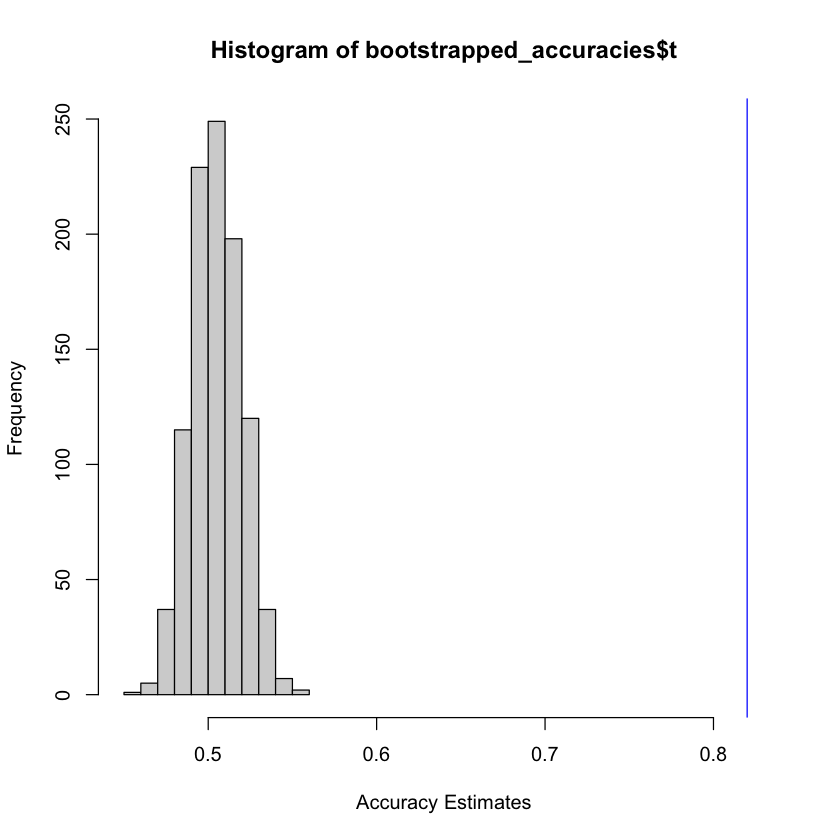

In [56]:
hist(bootstrapped_accuracies$t, xlab = 'Accuracy Estimates', xlim=c(0.45, 0.83))
abline(v=.82,col="blue")

accuracy_mean <- mean(bootstrapped_accuracies$t)
accuracy_sd <- sd(bootstrapped_accuracies$t)

error <- qnorm(0.975)*accuracy_sd/sqrt(1000)
left <- accuracy_mean - error
right <- accuracy_mean + error

print(paste('confidence intervals:', left,',', right))

How robust is the prediction accuracy of the full model?

> The prediction accuracy of the full model is quite good, at 82%. However, bootstrapping reveals that the accuracy is not robust, since the estimates for the bootstrapped samples are much lower, around 50, which is chance.
> 

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

In [31]:
permuted <- d1 #to be permuted in the for loop

n_observations = dim(d1)[1]

r_permutations = 1000

permuted_accuracies=matrix(NA,nrow = r_permutations , ncol=1) #filling with nas at first

for(i in 1:r_permutations) {
      permuted$FS_Total_GM_Vol <- d1$FS_Total_GM_Vol[sample(n_observations)] # randomly shuffle grey matter
    
      logistic_gender_model <- glm(as.factor(Gender_numeric) ~ FS_Total_GM_Vol + FS_IntraCranial_Vol + FS_Tot_WM_Vol, data = permuted, family = 'binomial')
      y_hat <- data.frame(predict(logistic_gender_model, type = "response"))
      y_hat <- data.frame(y_hat[,1])
      colnames(y_hat) <- "predicted_value"

      y_hat$predicted_gender <- ifelse(y_hat$predicted_value > threshold, 1, 0)
      y_hat$true_gender <- d1$Gender_numeric
      y_hat <- y_hat %>%
        mutate(Correct = predicted_gender == true_gender)

      permuted_accuracies[i] <- mean(y_hat$Correct)
    
    }


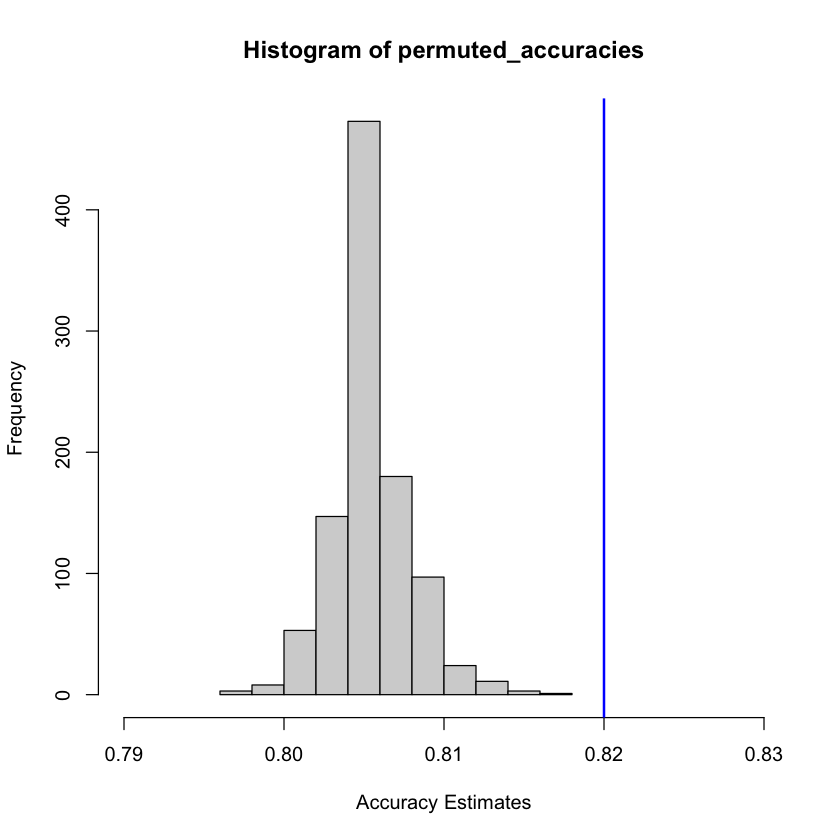

In [49]:
hist(permuted_accuracies, xlab = 'Accuracy Estimates', xlim=c(0.79,0.83))
abline(v=0.82,col="blue",lwd=2)

How much does the grey matter volume influence the prediction accuracy of the model?

> While the model does slightly better when grey matter is not permuted, there is not a large increase in prediction accuracy (82% compared to about 80%).
> 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> A bootstrap test is used to determine the robust-ness of the model parameters (e.g., coefficients, accuarcy for a classifier). It uses sampling with replacement to generate different patterns of the relationship between x and y. A permutation test is used to generate the null distribution by breaking the relationship between x and y. It can be used to examine how different a model/classifier would be if the relationship between x and y were random. 
> Permutaiton tests and bootstrap tests ask very different questions. You should use a permutation test to determine the importance of a relationship between x and y. You should use bootstrapping to determine the range of the effect of x on y. 

**DUE:** 5pm EST, April 1, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> Julia Conti, Asal Yunusova, Emefa Akwayena